## Data Preprocessing


The data is stored in the [NetCDF](https://en.wikipedia.org/wiki/NetCDF) files with _.nc_ extension. One of the distinct features of this format is the **named** specification to the coordinates and the data variables. 

As shown below, we first merge all the yearly NetCDF files, and display the structure of the format. xarray library is used to read the NetCDF files. It allows the users to manipulate data based on more informative labels instead of integer location. 



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from climate_learn.utils.data import load_dataset, view

# path = "/content/drive/MyDrive/Climate/.climate_learn/data/weatherbench/era5/5.625/2m_temperature"
path = "/data0/datasets/weatherbench/data/weatherbench/era5/5.625deg/total_precipitation"
dataset = load_dataset(path)
view(dataset)

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 350633)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 1979-01-01T07:00:00 ... 2018-12-31T23:00:00
Data variables:
    tp       (time, lat, lon) float32 dask.array<chunksize=(8753, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-01 16:44:41 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

In [3]:
from climate_learn.utils.datetime import Year, Days, Hours
from climate_learn.data import DataModule

data_module = DataModule(
    dataset = "ERA5",
    task = "forecasting",
    root_dir = "/data0/datasets/weatherbench/data/weatherbench/era5/5.625deg/",
    in_vars = ["2m_temperature"],
    out_vars = ["2m_temperature"],
    train_start_year = Year(1979),
    val_start_year = Year(2015),
    test_start_year = Year(2017),
    end_year = Year(2018),
    pred_range = Days(3),
    subsample = Hours(6),
    batch_size = 128,
    num_workers = 1
)

Creating train dataset
/data0/datasets/weatherbench/data/weatherbench/era5/5.625deg/


  0%|          | 0/36 [00:00<?, ?it/s]

Creating val dataset
/data0/datasets/weatherbench/data/weatherbench/era5/5.625deg/


  0%|          | 0/2 [00:00<?, ?it/s]

Creating test dataset
/data0/datasets/weatherbench/data/weatherbench/era5/5.625deg/


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
from climate_learn.models import load_model

# model_kwargs = {
#     "img_size": [32, 64],
#     "patch_size": 2,
#     "drop_path": 0.1,
#     "drop_rate": 0.1,
#     "learn_pos_emb": True,
#     "in_vars": data_module.hparams.in_vars,
#     "out_vars": data_module.hparams.out_vars,
#     "embed_dim": 128,
#     "depth": 8,
#     "decoder_depth": 0,
#     "num_heads": 4,
#     "mlp_ratio": 4,
# }

model_kwargs = {
    "in_channels": len(data_module.hparams.in_vars),
    "out_channels": len(data_module.hparams.out_vars),
    "n_blocks": 4
}

optim_kwargs = {
    "lr": 1e-4,
    "weight_decay": 1e-5,
    "warmup_epochs": 1,
    "max_epochs": 5,
}

# model_module = load_model(name = "vit", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)
model_module = load_model(name = "resnet", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)
# model_module = load_model(name = "unet", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)

In [5]:
# add_description
from climate_learn.models import set_climatology
set_climatology(model_module, data_module)

In [6]:
from climate_learn.training import Trainer, WandbLogger

trainer = Trainer(
    seed = 0,
    accelerator = "gpu",
    precision = 16,
    max_epochs = 5,
    # logger = WandbLogger(project = "climate_learn", name = "forecast-vit")
)

In [7]:
trainer.fit(model_module, data_module)

/home/jason.jewik/miniconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/jason.jewik/climate_learn/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name                       ┃ Type              ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ net                        │ ResNet            │  1.2 M │
│ 1  │ net.activation             │ LeakyReLU         │      0 │
│ 2  │ net.image_proj             │ PeriodicConv2D    │  6.4 K │
│ 3  │ net.image_proj.padding     │ PeriodicPadding2D │      0 │
│ 4  │ net.image_proj.conv        │ Conv2d            │  6.4 K │
│ 5  │ net.blocks                 │ ModuleList        │  1.2 M │
│ 6  │ net.blocks.0               │ ResidualBlock     │  295 K │
│ 7  │ net.blocks.0.activation    │ LeakyReLU         │      0 │
│ 8  │ net.blocks.0.conv1         │ PeriodicConv2D    │  147 K │
│ 9  │ net.blocks.0.conv1.padding │ PeriodicPadding2D │      0 │
│ 10 │ net.blocks.0.conv1.conv    │ Conv2d            │  147 K │
│ 11 │ net.blocks.0.conv2         │ PeriodicConv2D    │  147 K │
│ 12 │ net.blocks.0.conv2.padding │ PeriodicPadding2D │      0 │
│ 13 │ net.blocks.0.conv2.conv    │ Conv2d            │  147 K │
│ 14 │ net.blocks.0.shortcut      │ Identity          │      0 │
│ 15 │ net.blocks.0.norm1         │ BatchNorm2d       │    256 │
│ 16 │ net.blocks.0.norm2         │ BatchNorm2d       │    256 │
│ 17 │ net.blocks.0.drop          │ Dropout           │      0 │
│ 18 │ net.blocks.1               │ ResidualBlock     │  295 K │
│ 19 │ net.blocks.1.activation    │ LeakyReLU         │      0 │
│ 20 │ net.blocks.1.conv1         │ PeriodicConv2D    │  147 K │
│ 21 │ net.blocks.1.conv1.padding │ PeriodicPadding2D │      0 │
│ 22 │ net.blocks.1.conv1.conv    │ Conv2d            │  147 K │
│ 23 │ net.blocks.1.conv2         │ PeriodicConv2D    │  147 K │
│ 24 │ net.blocks.1.conv2.padding │ PeriodicPadding2D │      0 │
│ 25 │ net.blocks.1.conv2.conv    │ Conv2d            │  147 K │
│ 26 │ net.blocks.1.shortcut      │ Identity          │      0 │
│ 27 │ net.blocks.1.norm1         │ BatchNorm2d       │    256 │
│ 28 │ net.blocks.1.norm2         │ BatchNorm2d       │    256 │
│ 29 │ net.blocks.1.drop          │ Dropout           │      0 │
│ 30 │ net.blocks.2               │ ResidualBlock     │  295 K │
│ 31 │ net.blocks.2.activation    │ LeakyReLU         │      0 │
│ 32 │ net.blocks.2.conv1         │ PeriodicConv2D    │  147 K │
│ 33 │ net.blocks.2.conv1.padding │ PeriodicPadding2D │      0 │
│ 34 │ net.blocks.2.conv1.conv    │ Conv2d            │  147 K │
│ 35 │ net.blocks.2.conv2         │ PeriodicConv2D    │  147 K │
│ 36 │ net.blocks.2.conv2.padding │ PeriodicPadding2D │      0 │
│ 37 │ net.blocks.2.conv2.conv    │ Conv2d            │  147 K │
│ 38 │ net.blocks.2.shortcut      │ Identity          │      0 │
│ 39 │ net.blocks.2.norm1         │ BatchNorm2d       │    256 │
│ 40 │ net.blocks.2.norm2         │ BatchNorm2d       │    256 │
│ 41 │ net.blocks.2.drop          │ Dropout           │      0 │
│ 42 │ net.blocks.3               │ ResidualBlock     │  295 K │
│ 43 │ net.blocks.3.activation    │ LeakyReLU         │      0 │
│ 44 │ net.blocks.3.conv1         │ PeriodicConv2D    │  147 K │
│ 45 │ net.blocks.3.conv1.padding │ PeriodicPadding2D │      0 │
│ 46 │ net.blocks.3.conv1.conv    │ Conv2d            │  147 K │
│ 47 │ net.blocks.3.conv2         │ PeriodicConv2D    │  147 K │
│ 48 │ net.blocks.3.conv2.padding │ PeriodicPadding2D │      0 │
│ 49 │ net.blocks.3.conv2.conv    │ Conv2d            │  147 K │
│ 50 │ net.blocks.3.shortcut      │ Identity          │      0 │
│ 51 │ net.blocks.3.norm1         │ BatchNorm2d       │    256 │
│ 52 │ net.blocks.3.norm2         │ BatchNorm2d       │    256 │
│ 53 │ net.blocks.3.drop          │ Dropout           │      0 │
│ 54 │ net.norm                   │ BatchNorm2d       │    256 │
│ 55 │ net.final                  │ PeriodicConv2D    │  6.3 K │
│ 56 │ net.final.padding          │ PeriodicPadding2D │      0 │
│ 57 │ net.final.conv             │ Conv2d            │  6.3 K │
│ 58 │ denormalization            │

Trainable params: 1.2 M                                                                      
Non-trainable params: 0                                                                      
Total params: 1.2 M                                                                          
Total estimated model params size (MB): 2

Output()

/home/jason.jewik/miniconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/train
er/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, val_dataloader 0, 
does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` (try 64 which is the number of cpus on this machine) in the 
`DataLoader` init to improve performance.
  category=PossibleUserWarning,

/home/jason.jewik/miniconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/train
er/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, train_dataloader, 
does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` (try 64 which is the number of cpus on this machine) in the 
`DataLoader` init to improve performance.
  category=PossibleUserWarning,

/home/jason.jewik/miniconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/train
er/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")

## Evaluation 


In [8]:
trainer.test(model_module, data_module)

Output()

/home/jason.jewik/miniconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Test metric                 ┃                DataLoader 0                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/acc_2m_temperature_day_3        │            -0.012671333329768464            │
│      test/w_rmse_2m_temperature_day_3       │             18.656500474002573              │
│ test_climatology_baseline/w_rmse_2m_temper… │              5.88424715407195               │
└─────────────────────────────────────────────┴─────────────────────────────────────────────┘

## Visualization 

We visualize the **bias**, given by the difference in the predicted and the ground truth values, to better analyze our learned model.

Visualization is done on the test set. We can either specify exact time for the initial condition, or randomly sample from the test set.

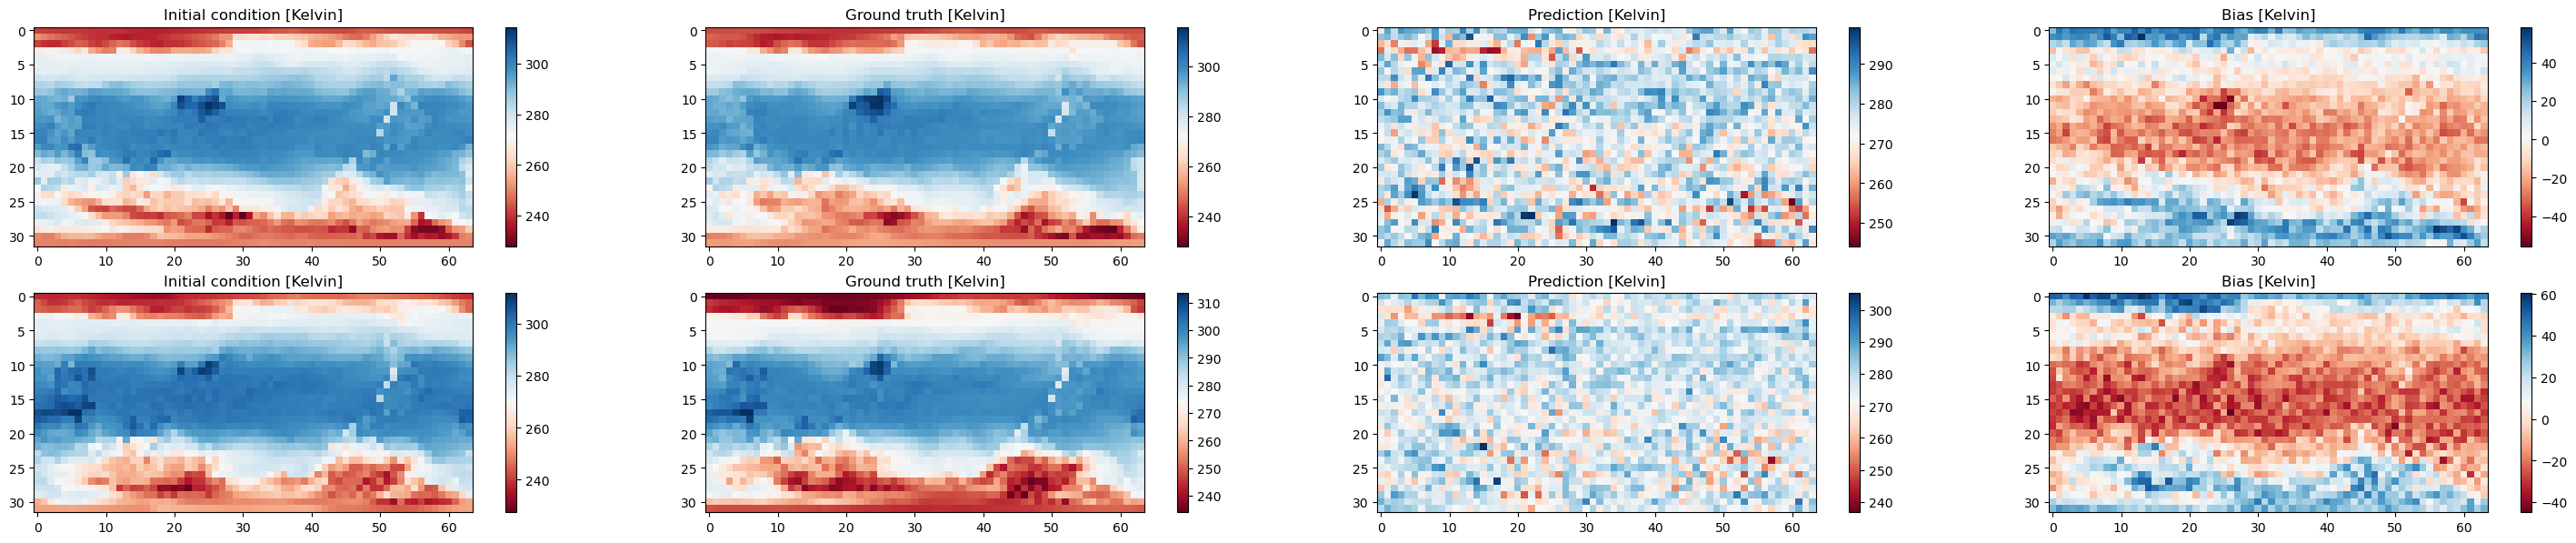

In [9]:
# from climate_learn.utils import visualize

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def visualize(model_module, data_module, split = "test", samples = 2, save_dir = None):
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok = True)

    # dataset.setup()
    dataset = eval(f"data_module.{split}_dataset")

    if(type(samples) == int):
        idxs = random.sample(range(0, len(dataset)), samples)
    elif(type(samples) == list):
        idxs = [np.searchsorted(dataset.time, np.datetime64(datetime.strptime(dt, "%Y-%m-%d:%H"))) for dt in samples]
    else:
        raise Exception("Invalid type for samples; Allowed int or list[datetime.datetime or np.datetime64]")

    fig, axes = plt.subplots(len(idxs), 4, figsize=(30, 3 * len(idxs)), squeeze = False)

    for index, idx in enumerate(idxs):
        x, y, _, _ = dataset[idx] # 1, 1, 32, 64
        pred = model_module.forward(x.unsqueeze(0)) # 1, 1, 32, 64

        inv_normalize = model_module.denormalization
        init_condition, gt = inv_normalize(x), inv_normalize(y)
        pred = inv_normalize(pred)
        bias = pred - gt

        for i, tensor in enumerate([init_condition, gt, pred, bias]):
            ax = axes[index][i]
            im = ax.imshow(tensor.detach().squeeze().cpu().numpy())
            im.set_cmap(cmap=plt.cm.RdBu)
            fig.colorbar(im, ax=ax)

        if(data_module.hparams.task == "forecasting"):
            axes[index][0].set_title("Initial condition [Kelvin]")
            axes[index][1].set_title("Ground truth [Kelvin]")
            axes[index][2].set_title("Prediction [Kelvin]")
            axes[index][3].set_title("Bias [Kelvin]")
        elif(data_module.hparams.task == "downscaling"):
            axes[index][0].set_title("Low resolution data [Kelvin]")
            axes[index][1].set_title("High resolution data [Kelvin]")
            axes[index][2].set_title("Downscaled [Kelvin]")
            axes[index][3].set_title("Bias [Kelvin]")
        else:
            raise NotImplementedError

    fig.tight_layout()
    
    if save_dir is not None:
        plt.savefig(os.path.join(save_dir, 'visualize.png'))
    else:
        plt.show()

# if samples = 2, we randomly pick 2 initial conditions in the test set
visualize(model_module, data_module, samples = ["2017-06-01:12", "2017-08-01:18"])

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:21<00:00,  6.34it/s]


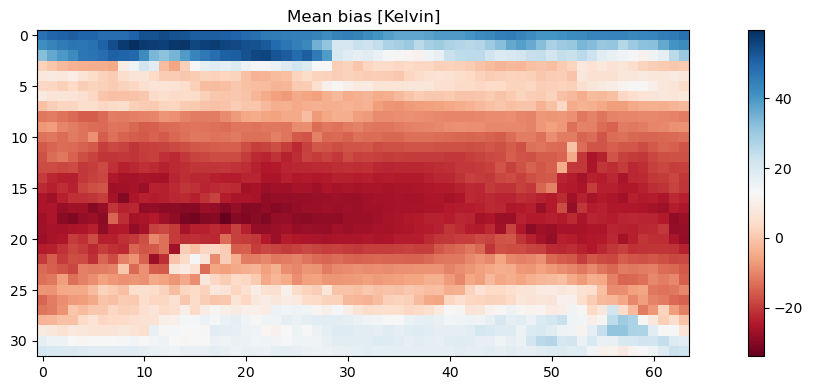

In [10]:
import torch
from tqdm import tqdm

def visualize_mean_bias(model_module, data_module, save_dir = None):
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok = True)

    loader = data_module.test_dataloader()

    all_mean_bias = []
    for batch in tqdm(loader):
        x, y, _, _ = batch # B, 1, 32, 64
        x = x.to(model_module.device)
        y = y.to(model_module.device)
        pred = model_module.forward(x) # B, 1, 32, 64

        inv_normalize = model_module.denormalization
        init_condition, gt = inv_normalize(x), inv_normalize(y)
        pred = inv_normalize(pred)
        bias = pred - gt # B, 1, 32, 64
        mean_bias = bias.mean(dim=0)
        all_mean_bias.append(mean_bias)
    
    all_mean_bias = torch.stack(all_mean_bias, dim=0)
    mean_bias = torch.mean(all_mean_bias, dim=0)

    fig, axes = plt.subplots(1, 1, figsize=(12, 4), squeeze = False)
    ax = axes[0,0]

    im = ax.imshow(mean_bias.detach().squeeze().cpu().numpy())
    im.set_cmap(cmap=plt.cm.RdBu)
    fig.colorbar(im, ax=ax)
    ax.set_title("Mean bias [Kelvin]")

    fig.tight_layout()
    
    if save_dir is not None:
        plt.savefig(os.path.join(save_dir, 'visualize_mean_bias.png'))
    else:
        plt.show()

visualize_mean_bias(model_module.cuda(), data_module)

In [11]:
from climate_learn.utils.datetime import Year, Days, Hours
from climate_learn.data import DataModule

data_module = DataModule(
    dataset = "ERA5",
    task = "downscaling",
    root_dir = "/data0/datasets/weatherbench/data/weatherbench/era5/5.625deg/",
    root_highres_dir = "/data0/datasets/weatherbench/data/weatherbench/era5/2.8125deg/",
    in_vars = ["2m_temperature"],
    out_vars = ["2m_temperature"],
    train_start_year = Year(1979),
    val_start_year = Year(2015),
    test_start_year = Year(2017),
    end_year = Year(2018),
    subsample = Hours(6),
    batch_size = 128,
    num_workers = 1
)

Creating train dataset
/data0/datasets/weatherbench/data/weatherbench/era5/5.625deg/


  0%|          | 0/36 [00:00<?, ?it/s]

/data0/datasets/weatherbench/data/weatherbench/era5/2.8125deg/


  0%|          | 0/36 [00:00<?, ?it/s]

Creating val dataset
/data0/datasets/weatherbench/data/weatherbench/era5/5.625deg/


  0%|          | 0/2 [00:00<?, ?it/s]

/data0/datasets/weatherbench/data/weatherbench/era5/2.8125deg/


  0%|          | 0/2 [00:00<?, ?it/s]

Creating test dataset
/data0/datasets/weatherbench/data/weatherbench/era5/5.625deg/


  0%|          | 0/2 [00:00<?, ?it/s]

/data0/datasets/weatherbench/data/weatherbench/era5/2.8125deg/


  0%|          | 0/2 [00:00<?, ?it/s]

## Model initialization

In [12]:
from climate_learn.models import load_model

# model_kwargs = {
#     "img_size": [32, 64],
#     "patch_size": 4,
#     "drop_path": 0.1,
#     "drop_rate": 0.1,
#     "learn_pos_emb": True,
#     "in_vars": data_module.hparams.in_vars,
#     "out_vars": data_module.hparams.out_vars,
#     "upsampling": data_module.train_dataset.downscale_ratio,
#     "embed_dim": 128,
#     "depth": 8,
#     "decoder_depth": 0,
#     "num_heads": 4,
#     "mlp_ratio": 4,
# }

model_kwargs = {
    "in_channels": len(data_module.hparams.in_vars),
    "out_channels": len(data_module.hparams.out_vars),
    "upsampling": data_module.train_dataset.downscale_ratio,
    "n_blocks": 4,
}

optim_kwargs = {
    "optimizer": "adamw",
    "lr": 1e-4,
    "weight_decay": 1e-5,
    "warmup_epochs": 1,
    "max_epochs": 5,
}

# model_module = load_model(name = "vit", task = "downscaling", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)
model_module = load_model(name = "resnet", task = "downscaling", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)
# model_module = load_model(name = "unet", task = "downscaling", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)

In [13]:
# latitude long info, 
from climate_learn.models import set_climatology
set_climatology(model_module, data_module)

## Training

In [14]:
from climate_learn.training import Trainer, WandbLogger

trainer = Trainer(
    seed = 0,
    accelerator = "gpu",
    precision = 16,
    max_epochs = 5,
    # logger = WandbLogger(project = "climate_learn", name = "downscale-vit")
)

In [15]:
trainer.fit(model_module, data_module)

/home/jason.jewik/miniconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/jason.jewik/climate_learn/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name                       ┃ Type              ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ net                        │ ResNet            │  1.5 M │
│ 1  │ net.activation             │ LeakyReLU         │      0 │
│ 2  │ net.image_proj             │ PeriodicConv2D    │  6.4 K │
│ 3  │ net.image_proj.padding     │ PeriodicPadding2D │      0 │
│ 4  │ net.image_proj.conv        │ Conv2d            │  6.4 K │
│ 5  │ net.blocks                 │ ModuleList        │  1.4 M │
│ 6  │ net.blocks.0               │ ResidualBlock     │  295 K │
│ 7  │ net.blocks.0.activation    │ LeakyReLU         │      0 │
│ 8  │ net.blocks.0.conv1         │ PeriodicConv2D    │  147 K │
│ 9  │ net.blocks.0.conv1.padding │ PeriodicPadding2D │      0 │
│ 10 │ net.blocks.0.conv1.conv    │ Conv2d            │  147 K │
│ 11 │ net.blocks.0.conv2         │ PeriodicConv2D    │  147 K │
│ 12 │ net.blocks.0.conv2.padding │ PeriodicPadding2D │      0 │
│ 13 │ net.blocks.0.conv2.conv    │ Conv2d            │  147 K │
│ 14 │ net.blocks.0.shortcut      │ Identity          │      0 │
│ 15 │ net.blocks.0.norm1         │ BatchNorm2d       │    256 │
│ 16 │ net.blocks.0.norm2         │ BatchNorm2d       │    256 │
│ 17 │ net.blocks.0.drop          │ Dropout           │      0 │
│ 18 │ net.blocks.1               │ ResidualBlock     │  295 K │
│ 19 │ net.blocks.1.activation    │ LeakyReLU         │      0 │
│ 20 │ net.blocks.1.conv1         │ PeriodicConv2D    │  147 K │
│ 21 │ net.blocks.1.conv1.padding │ PeriodicPadding2D │      0 │
│ 22 │ net.blocks.1.conv1.conv    │ Conv2d            │  147 K │
│ 23 │ net.blocks.1.conv2         │ PeriodicConv2D    │  147 K │
│ 24 │ net.blocks.1.conv2.padding │ PeriodicPadding2D │      0 │
│ 25 │ net.blocks.1.conv2.conv    │ Conv2d            │  147 K │
│ 26 │ net.blocks.1.shortcut      │ Identity          │      0 │
│ 27 │ net.blocks.1.norm1         │ BatchNorm2d       │    256 │
│ 28 │ net.blocks.1.norm2         │ BatchNorm2d       │    256 │
│ 29 │ net.blocks.1.drop          │ Dropout           │      0 │
│ 30 │ net.blocks.2               │ ResidualBlock     │  295 K │
│ 31 │ net.blocks.2.activation    │ LeakyReLU         │      0 │
│ 32 │ net.blocks.2.conv1         │ PeriodicConv2D    │  147 K │
│ 33 │ net.blocks.2.conv1.padding │ PeriodicPadding2D │      0 │
│ 34 │ net.blocks.2.conv1.conv    │ Conv2d            │  147 K │
│ 35 │ net.blocks.2.conv2         │ PeriodicConv2D    │  147 K │
│ 36 │ net.blocks.2.conv2.padding │ PeriodicPadding2D │      0 │
│ 37 │ net.blocks.2.conv2.conv    │ Conv2d            │  147 K │
│ 38 │ net.blocks.2.shortcut      │ Identity          │      0 │
│ 39 │ net.blocks.2.norm1         │ BatchNorm2d       │    256 │
│ 40 │ net.blocks.2.norm2         │ BatchNorm2d       │    256 │
│ 41 │ net.blocks.2.drop          │ Dropout           │      0 │
│ 42 │ net.blocks.3               │ ResidualBlock     │  295 K │
│ 43 │ net.blocks.3.activation    │ LeakyReLU         │      0 │
│ 44 │ net.blocks.3.conv1         │ PeriodicConv2D    │  147 K │
│ 45 │ net.blocks.3.conv1.padding │ PeriodicPadding2D │      0 │
│ 46 │ net.blocks.3.conv1.conv    │ Conv2d            │  147 K │
│ 47 │ net.blocks.3.conv2         │ PeriodicConv2D    │  147 K │
│ 48 │ net.blocks.3.conv2.padding │ PeriodicPadding2D │      0 │
│ 49 │ net.blocks.3.conv2.conv    │ Conv2d            │  147 K │
│ 50 │ net.blocks.3.shortcut      │ Identity          │      0 │
│ 51 │ net.blocks.3.norm1         │ BatchNorm2d       │    256 │
│ 52 │ net.blocks.3.norm2         │ BatchNorm2d       │    256 │
│ 53 │ net.blocks.3.drop          │ Dropout           │      0 │
│ 54 │ net.blocks.4               │ Upsample          │  262 K │
│ 55 │ net.blocks.4.conv          │ ConvTranspose2d   │  262 K │
│ 56 │ net.norm                   │ BatchNorm2d       │    256 │
│ 57 │ net.final                  │ PeriodicConv2D    │  6.3 K │
│ 58 │ net.final.padding          │

Trainable params: 1.5 M                                                                      
Non-trainable params: 0                                                                      
Total params: 1.5 M                                                                          
Total estimated model params size (MB): 2

Output()

/home/jason.jewik/miniconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/train
er/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, val_dataloader 0, 
does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` (try 64 which is the number of cpus on this machine) in the 
`DataLoader` init to improve performance.
  category=PossibleUserWarning,

/home/jason.jewik/miniconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/train
er/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, train_dataloader, 
does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` (try 64 which is the number of cpus on this machine) in the 
`DataLoader` init to improve performance.
  category=PossibleUserWarning,

/home/jason.jewik/miniconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/train
er/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")

## Evaluation

In [16]:
trainer.test(model_module, data_module)

Output()

/home/jason.jewik/miniconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test/mean_bias_2m_temperature │      -3.7623019218444824      │
│ test/pearsonr_2m_temperature  │     -0.15906723657203742      │
│   test/rmse_2m_temperature    │       22.28522491455078       │
└───────────────────────────────┴───────────────────────────────┘

## Visualization 

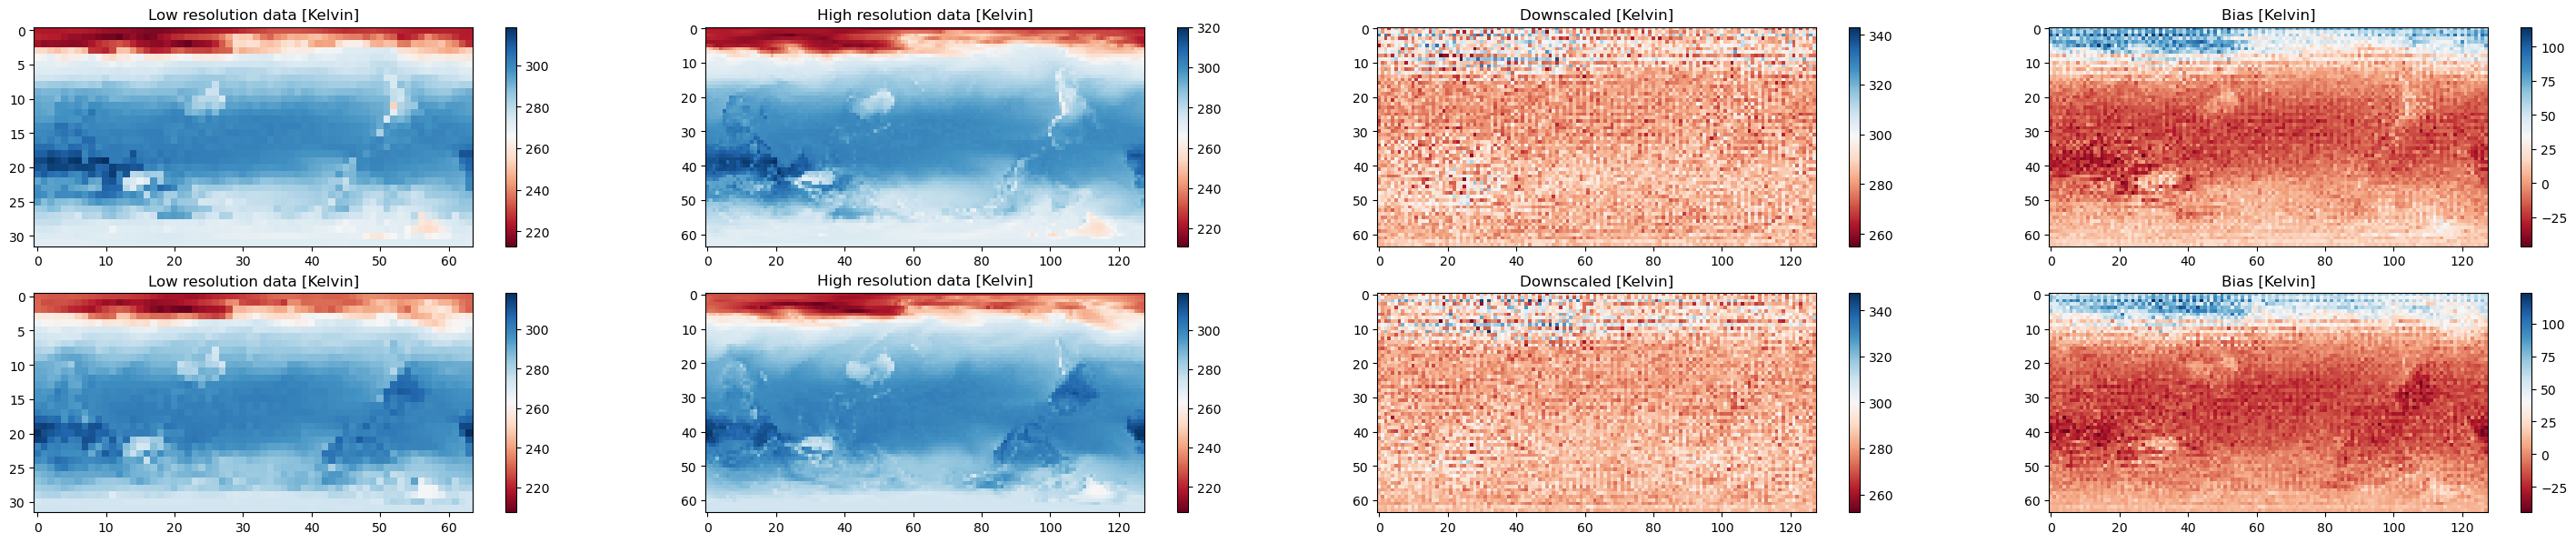

In [17]:
# from climate_learn.utils import visualize
# visualize(model_module, data_module)
visualize(model_module, data_module, samples = ["2017-06-01:12", "2017-08-01:18"])

## Potential Applications of the Tutorial


1. Our package with this tutorial makes it easy for the practitioners to focus on the machine learning model design and evaluate their models against standard benchmarks such as Weatherbench ([Leaderboard](https://github.com/pangeo-data/WeatherBench)) using our evaluation support. 
2. The climate experts can load and train their customized machine learning models with various hyperparameters. For instance, they can study the effect of varying the capacity of machine learning models on its predictions.
3. To best of our knowledge, this is the only package that provides support for temporal forecasting and spatial downscaling under the hood. It helps the forecasting community to benefit from the improvements in modeling downscaling and vice-versa.

## Limitations


1. Due to the noise involved in capturing climate variables, climate modeling is particularly a challenging task. Different datasets such as ERA5, CMIP6 may contain different values for a particular climate variable. 
2. This tutorial does not cover the aspect of uncertainity in the model predictions. We shall add more capabilities to our models in the package for climate modelers to quantify the error in the predicted output.
3. There is a massive amount of climate data available (~10 TBs), our tutorial does not cover aspects of how to deal with the data at that scale which might be important for capturing more sophisticated climate phenomenon.

# Submitting the Tutorial
*(Please remove this section from your final tutorial submission.)*

If you are using Google Colab, make sure to change the permissions by clicking "Share" (upper right corner of the notebook) >> Change permissions to "Anyone on the internet with this link can comment". 

For additional questions, please feel free to contact:
*   climatechangeai.neurips2022@gmail.com
*   tutorials@climatechange.ai